# RNNs: How To Implement A Basic RNN

### Read In, Clean, And Split The Data

Create a env for all the libraries you want to use for your project, best to use an anaconda environment.

In [23]:
# Read in data and split into training and test set
# NOTE: we are NOT cleaning the data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('../../../data/spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
print(messages)
messages.columns = ["label", "text"]
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'],
                                                    labels, test_size=0.2)

        v1  \
0      ham   
1      ham   
2     spam   
3      ham   
4      ham   
...    ...   
5567  spam   
5568   ham   
5569   ham   
5570   ham   
5571   ham   

                                                                                                                                                                     v2  
0                                                       Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...  
1                                                                                                                                         Ok lar... Joking wif u oni...  
2           Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's  
3                                                                                                                     U dun say so early hor... U c alr

In [22]:
X_train.iloc[0]


array([0, 0, 0, ..., 0, 0, 0])

### Prep Data For Modeling

In [ ]:
# Install keras, runs on top of tensorflow better UI
# %pip install keras

In [ ]:
# Import the tools we will need from keras
# %pip install tensorflow
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

2024-07-22 15:41:48.631446: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [5]:
# Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [7]:
# What do these sequences look like?
X_train_seq[0]

[509, 36, 435, 4, 2555, 317, 37, 60, 3779, 2556, 42, 2557]

In [9]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [10]:
# What do these padded sequences look like?
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  509,   36,  435,    4, 2555,  317,
         37,   60, 3779, 2556,   42, 2557], dtype=int32)

### Build Model

In [24]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K #Computing metrics for us
from keras.layers import Dense, Embedding, LSTM #Long short term memory
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [26]:
# Construct a simple RNN model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))  # Remove extra closing parenthesis here
model.add(Dense(32, activation='relu')) #What is relu?
model.add(Dense(1, activation='sigmoid')) # What is sigmoid?
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          251872    
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 261,281
Trainable params: 261,281
Non-trainable params: 0
_________________________________________________________________


2024-07-22 16:18:55.725039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-22 16:18:55.727314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-22 16:18:55.728194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [27]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [28]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10


2024-07-22 16:20:05.597159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-22 16:20:05.598337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-22 16:20:05.599473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

138/140 [============================>.] - ETA: 0s - loss: 0.4402 - accuracy: 0.8585 - precision_m: 7.2464e-04 - recall_m: 0.0024

2024-07-22 16:20:09.847687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-22 16:20:09.849639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-22 16:20:09.850785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

140/140 [==============================] - 5s 19ms/step - loss: 0.4404 - accuracy: 0.8582 - precision_m: 7.1429e-04 - recall_m: 0.0024 - val_loss: 0.3724 - val_accuracy: 0.8780 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/10
140/140 [==============================] - 2s 15ms/step - loss: 0.3844 - accuracy: 0.8629 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.3808 - val_accuracy: 0.8780 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/10
140/140 [==============================] - 2s 15ms/step - loss: 0.3021 - accuracy: 0.8741 - precision_m: 0.3904 - recall_m: 0.1932 - val_loss: 0.4445 - val_accuracy: 0.8673 - val_precision_m: 0.1429 - val_recall_m: 0.0381
Epoch 4/10
140/140 [==============================] - 2s 15ms/step - loss: 0.2094 - accuracy: 0.9147 - precision_m: 0.7350 - recall_m: 0.5646 - val_loss: 0.5462 - val_accuracy: 0.8126 - val_precision_m: 0.2178 - val_recall_m: 0.1121
Epoch 5/10
140/140 [==============================]

In [30]:
%pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.5 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp311-cp311-macosx_10_9_x86_64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 19.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.1/262.1 kB 17.6 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 16.1 MB/s eta 0:00:00a 0:00:01
Using cached kiwisolver-1.4.5-cp311-cp311-macosx_10_9_x86_64.whl (68 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 26.1 MB/s eta 0:00:0000:0100:01
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)
Note: you may need to restart the kernel to use updated packages.


Matplotlib is building the font cache; this may take a moment.


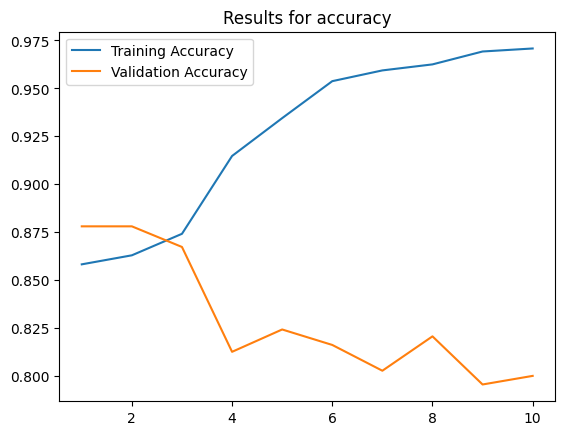

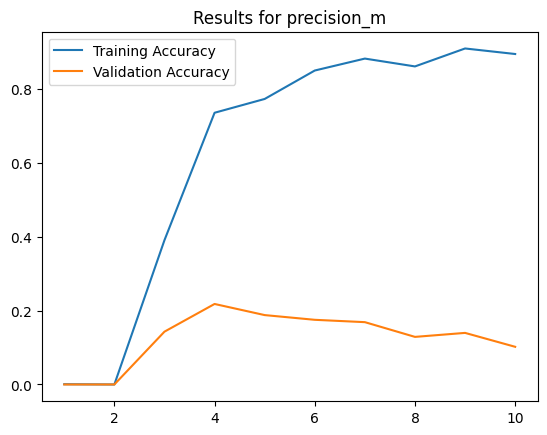

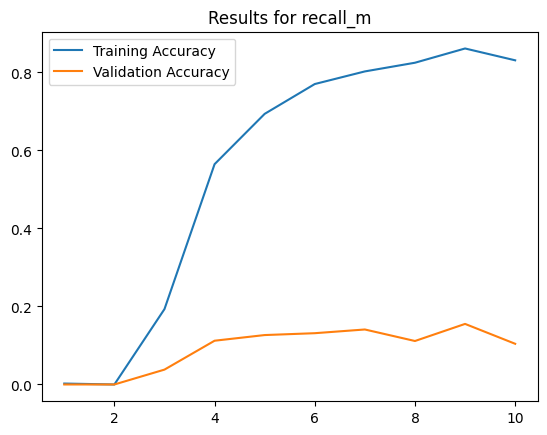

In [31]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt


for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()